# Занятие 2. Разбор методов построения uplift-моделей.

## About the problem

Данные из экспериментов рекламной платформы Criteo. См. http://ailab.criteo.com/criteo-uplift-prediction-dataset/

Суть экспериментов - на части пользователей (контрольная группа) отключается таргетированная реклама. 

В датасете содержится информация о 25M пользователях. Каждый из них описывается
* 12 признаками, зафиксированными на начало эксперимента
* флагом группы
* флагами посещения сайта рекламодателя (visit) и конверсии в покупку (conversion)

Описание полей 
* f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11: признаки пользователя (dense, float)
* treatment: в какой группе пользователь (1 = treated, 0 = control)
* conversion: флаг конверсии (binary, label)
* visit: флаг визита (binary, label)

## Head

In [1]:
import pandas as pd
import sidetable
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from IPython.display import Image

In [2]:
import causalml
import causalml.metrics as cmetrics
import causalml.inference.tree as ctree
import causalml.inference.meta.xlearner as xlearner
import causalml.inference.meta.rlearner as rlearner
import causalml.inference.meta.tlearner as tlearner

import pylift
import catboost as cb
import lightgbm as lgb

from sklearn.model_selection import train_test_split

In [3]:
from IPython.display import Image

In [4]:
import causalml.inference.tree as ctree

In [5]:
import causalml.inference.meta.xlearner as xlearner

In [6]:
from scipy.stats import chi2_contingency

In [7]:
from typing import List, Tuple

## Lib

In [8]:
def proportion_diff_interval(success: pd.Series, nobs: pd.Series, conf_level: float = 0.05):
    assert len(success) == 2 and len(nobs) == 2
    p = np.array(success) / np.array(nobs)
    z = sp.stats.norm.ppf(1.0 - conf_level)
    diff = p[1] - p[0]
    std_dev = np.sqrt(p[0] * (1.0 - p[0]) / nobs[0] + p[1] * (1.0 - p[1]) / nobs[1])
    pvalue = 2 * sp.stats.norm.cdf(-np.abs(diff) / std_dev)
    return diff, std_dev, pvalue, (diff - z * std_dev, diff + z * std_dev)


def response_uplift(
    data: pd.DataFrame,
    col_feature: str,
    col_target: str,
    col_treatment: str = 'treatment',
    conf_level: float = 0.05,
    verbose: bool = True,
    figsize: Tuple[int, int] = (10, 7),
    plot_type: str = 'default'
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    tmp = data.copy()
    tmp['tmp_response'] = list(map(int, tmp[col_target] > 0))
    
    response_pivot = tmp.pivot_table(
        values='tmp_response', index=[col_feature], columns=[col_treatment],
        aggfunc='sum'
    )
    
    clients_pivot = tmp.pivot_table(
        values='tmp_response', index=[col_feature], columns=[col_treatment],
        aggfunc='count'
    )
    
    means = list()
    stds = list()
    pvalues = list()
    chi2_pvalues = list()
    
    for segment in response_pivot.index:
        m, std, pvalue, _ = proportion_diff_interval(response_pivot.loc[segment, :], clients_pivot.loc[segment, :], conf_level=conf_level)
        means.append(m)
        stds.append(std)
        pvalues.append(pvalue)
        
        try:
            chi2_pvalue = chi2_contingency([response_pivot.loc[segment, :], clients_pivot.loc[segment, :]])[1]
        except:
            chi2_pvalue = -1.0
        
        chi2_pvalues.append(chi2_pvalue)
        
    report = pd.DataFrame(
        data={
            'diff': means, 
            'std': stds, 
            'p-value': pvalues,
            'chi2_p-value': chi2_pvalues,
            'count_0': clients_pivot.loc[:, 0],
            'count_1': clients_pivot.loc[:, 1],
            'response_0': response_pivot.loc[:, 0],
            'response_1': response_pivot.loc[:, 1]
        }, 
        index=list(response_pivot.index)
    )
    
    if verbose:
        plt.figure(figsize=figsize)
        if plot_type == 'default':
            plt.errorbar(
                x=response_pivot.index,
                y=means,
                yerr=np.array(stds) * sp.stats.norm.ppf(1.0 - conf_level),
                fmt='ok'
            )
        elif plot_type == 'bin':
            plt.errorbar(
                x=range(len(response_pivot.index)),
                y=means,
                yerr=np.array(stds) * sp.stats.norm.ppf(1.0 - conf_level),
                fmt='ok'
            )
            plt.xticks(
                range(len(response_pivot.index)),
                response_pivot.index,
                rotation=20
            )
        plt.show()

    return report, response_pivot, clients_pivot


## Load'n'cook

### load

In [9]:
import os
FLD = "/home/nur/projects/analysis/uplift/data/hw2"
data = pd.read_csv(os.path.join(FLD, 'criteo-uplift-v2.1.csv'))

In [10]:
data.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


In [11]:
data.shape

(13979592, 16)

### cook

### column sets

In [12]:
cols_features = [
    "f0", "f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "f9", "f10", "f11"
]

col_treatment = 'treatment'

### splits

In [13]:
fit_index, val_index = train_test_split(data.index, test_size=0.2, random_state=165)

In [14]:
len(fit_index)

11183673

In [15]:
len(val_index)

2795919

In [16]:
_sample_treated_size = 100_000
_sample_control_size = 100_000
fit_sample_index = data.loc[fit_index, [col_treatment]].query(f'{col_treatment} == 1').sample(_sample_treated_size).index
fit_sample_index = fit_sample_index.union(
    data.loc[fit_index, [col_treatment]].query(f'{col_treatment} == 0').sample(_sample_control_size).index
)

In [17]:
_sample_treated_size = 100_000
_sample_control_size = 100_000
val_sample_index = data.loc[val_index, [col_treatment]].query(f'{col_treatment} == 1').sample(_sample_treated_size).index
val_sample_index = val_sample_index.union(
    data.loc[val_index, [col_treatment]].query(f'{col_treatment} == 0').sample(_sample_control_size).index
)

## EDA

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13979592 entries, 0 to 13979591
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          float64
 1   f1          float64
 2   f2          float64
 3   f3          float64
 4   f4          float64
 5   f5          float64
 6   f6          float64
 7   f7          float64
 8   f8          float64
 9   f9          float64
 10  f10         float64
 11  f11         float64
 12  treatment   int64  
 13  conversion  int64  
 14  visit       int64  
 15  exposure    int64  
dtypes: float64(12), int64(4)
memory usage: 1.7 GB


In [19]:
data

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13979587,26.297764,10.059654,9.006250,4.679882,10.280525,4.115453,-3.282109,4.833815,3.839578,13.190056,5.300375,-0.168679,1,0,0,0
13979588,12.642207,10.679513,8.214383,-1.700105,10.280525,3.013064,-13.955150,6.269026,3.971858,13.190056,5.300375,-0.168679,1,0,0,1
13979589,12.976557,10.059654,8.381868,0.842442,11.029584,4.115453,-8.281971,4.833815,3.779212,23.570168,6.169187,-0.168679,1,0,1,0
13979590,24.805064,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0


In [20]:
data.stb.missing()

,missing,total,percent
f0,0,13979592,0.0
f1,0,13979592,0.0
f2,0,13979592,0.0
f3,0,13979592,0.0
f4,0,13979592,0.0
f5,0,13979592,0.0
f6,0,13979592,0.0
f7,0,13979592,0.0
f8,0,13979592,0.0
f9,0,13979592,0.0


In [21]:
data.nunique()

f0            2181959
f1                 60
f2            2051900
f3                552
f4                260
f5                132
f6               1645
f7             622143
f8               3743
f9               1594
f10            517372
f11               136
treatment           2
conversion          2
visit               2
exposure            2
dtype: int64

In [22]:
data.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
count,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07
mean,1.962030e+01,1.006998e+01,8.446582e+00,4.178923e+00,1.033884e+01,4.028513e+00,-4.155356e+00,5.101765e+00,3.933581e+00,1.602764e+01,5.333396e+00,-1.709672e-01,8.500001e-01,2.916680e-03,4.699200e-02,3.063122e-02
std,5.377464e+00,1.047557e-01,2.993161e-01,1.336645e+00,3.433081e-01,4.310974e-01,4.577914e+00,1.205248e+00,5.665958e-02,7.018975e+00,1.682288e-01,2.283277e-02,3.570713e-01,5.392748e-02,2.116217e-01,1.723164e-01
min,1.261636e+01,1.005965e+01,8.214383e+00,-8.398387e+00,1.028053e+01,-9.011892e+00,-3.142978e+01,4.833815e+00,3.635107e+00,1.319006e+01,5.300375e+00,-1.383941e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.261636e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-6.699321e+00,4.833815e+00,3.910792e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.192341e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-2.411115e+00,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.443646e+01,1.005965e+01,8.723335e+00,4.679882e+00,1.028053e+01,4.115453e+00,2.944427e-01,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.674526e+01,1.634419e+01,9.051962e+00,4.679882e+00,2.112351e+01,4.115453e+00,2.944427e-01,1.199840e+01,3.971858e+00,7.529502e+01,6.473917e+00,-1.686792e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


### Как устроены treatment, visit и conversion?

In [23]:
data['treatment'].value_counts(normalize = True)

1    0.85
0    0.15
Name: treatment, dtype: float64

In [24]:
visit_pivot = data.groupby('treatment').agg({'visit': ['mean', 'sum', 'count']})
visit_pivot

visit                  
               mean     sum     count
treatment                            
0          0.038201   80105   2096937
1          0.048543  576824  11882655

In [25]:
conversion_pivot = data.groupby('treatment').agg({'conversion': ['mean', 'sum', 'count']})
conversion_pivot

conversion                 
                mean    sum     count
treatment                            
0           0.001938   4063   2096937
1           0.003089  36711  11882655

In [26]:
print(f'Difference in CTR rate between control and treatment: {np.round(data.groupby("treatment")["visit"].mean()[1] - data.groupby("treatment")["visit"].mean()[0], 4)}')
print(f'Difference in conversion between control and treatment: {np.round(data.groupby("treatment")["conversion"].mean()[1] - data.groupby("treatment")["conversion"].mean()[0], 4)}')

Difference in CTR rate between control and treatment: 0.0103
Difference in conversion between control and treatment: 0.0012


### Как устроены факторы?

#### Попарные зависимости и гистограммы

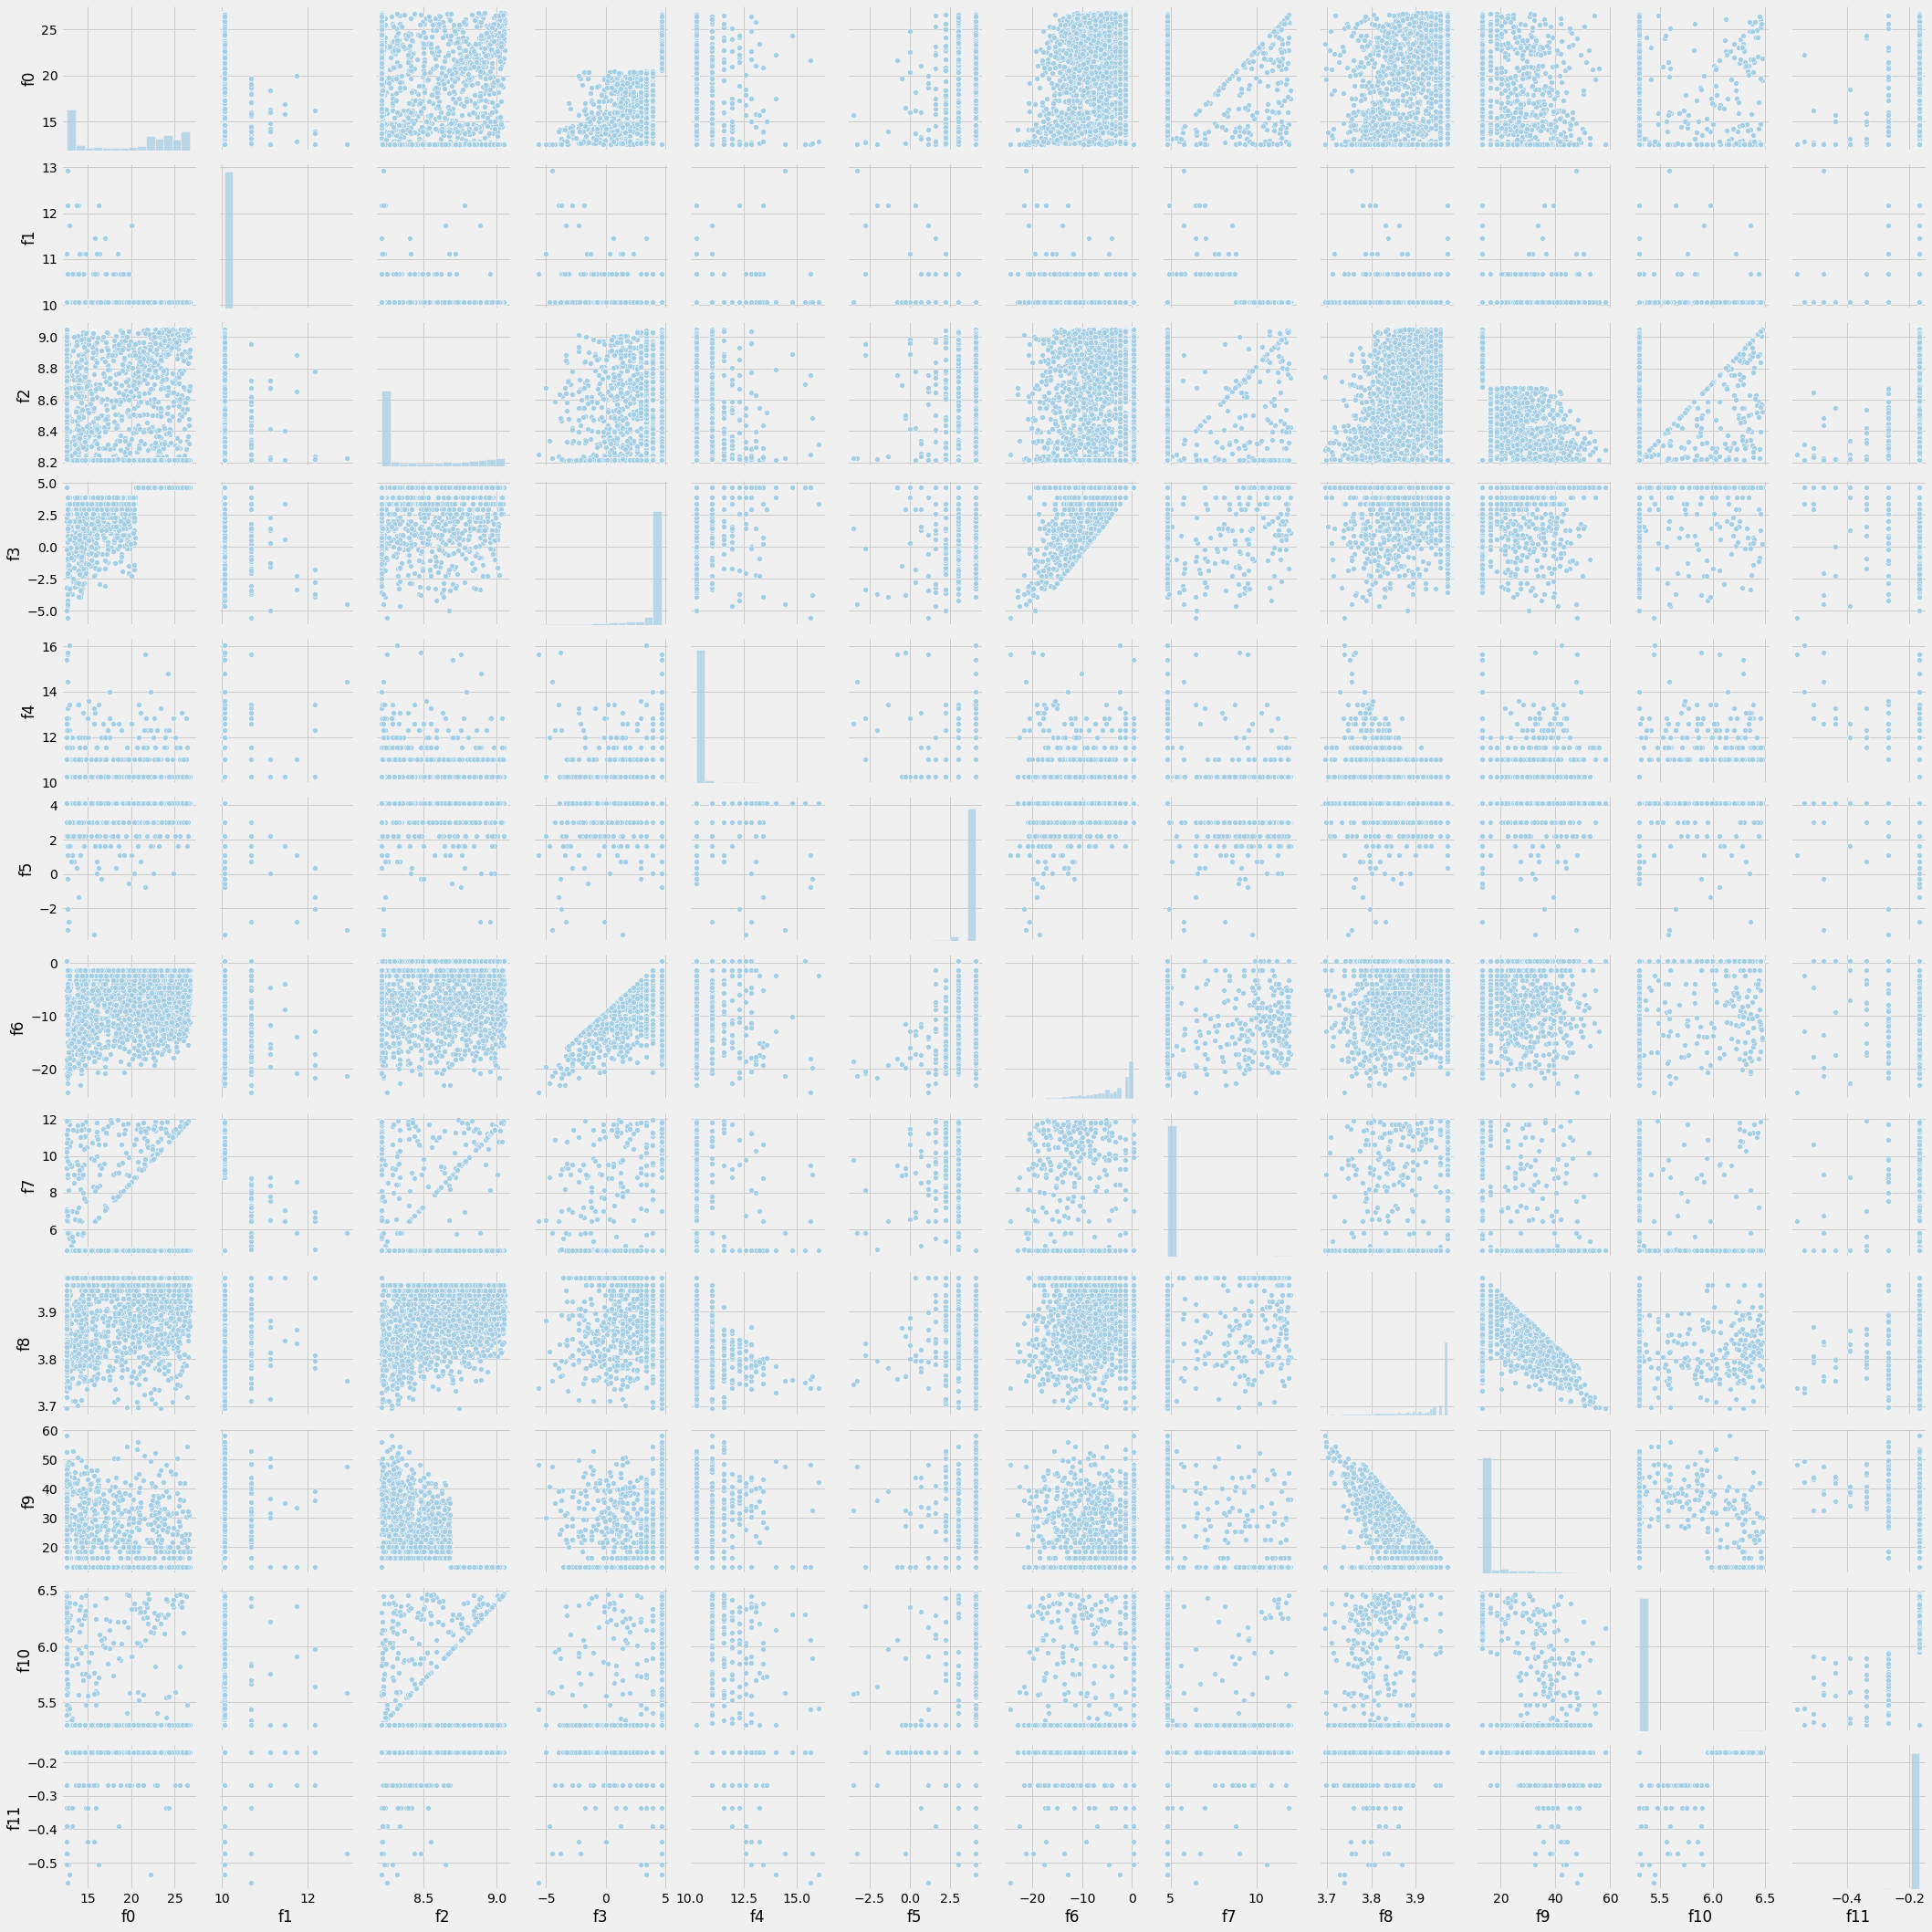

In [27]:
sns.pairplot(data[cols_features].sample(5000))

### Как uplift зависит от факторов?

#### Uplift  переменной visit в разрезе категориальных факторов

In [28]:
data['f1'].nunique()

60

In [29]:
data['f1'].value_counts().head(10)

10.059654    13807642
10.679513      123236
11.119309       26768
11.460441        9540
11.739167        4639
11.974826        2440
12.178963        1523
12.359025         969
12.520096         673
12.665802         490
Name: f1, dtype: int64

In [30]:
data['f1'].nunique()

60

invalid value encountered in double_scalars
divide by zero encountered in double_scalars


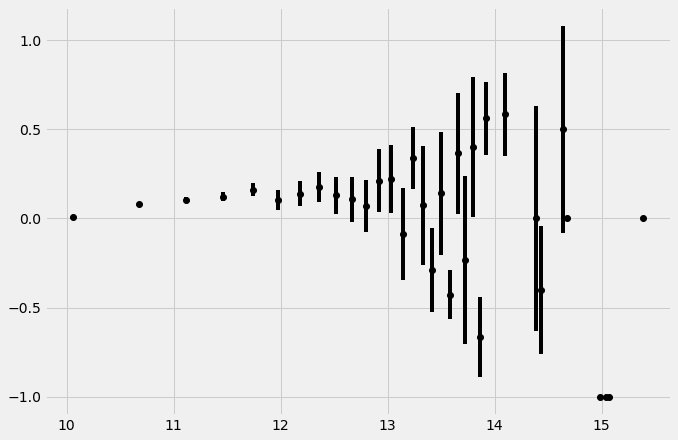

In [31]:
_ = response_uplift(
    data=data.loc[fit_index],
    col_feature='f1',
    col_target='visit',
    col_treatment=col_treatment
)

In [32]:
_col_feature = 'f6'
_data = data.loc[fit_index]
_data[_col_feature + '_bin'] = pd.qcut(_data[_col_feature], q=8, duplicates='drop') # .astype(str)

In [33]:
_data[_col_feature + '_bin'].value_counts()

(-1.288, 0.294]       2964000
(-4.595, -2.411]      2121906
(-2.411, -1.288]      1785720
(-10.144, -6.699]     1489188
(-6.699, -4.595]      1415192
(-31.431, -10.144]    1407667
Name: f6_bin, dtype: int64

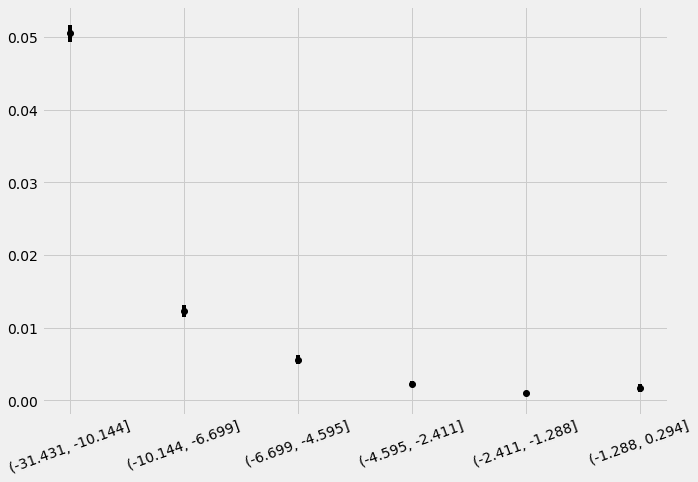

In [34]:
_ = response_uplift(
    data=_data,
    col_feature=_col_feature + '_bin',
    col_target='visit',
    col_treatment=col_treatment,
    plot_type='bin'
)

#### NWOE и NIV

(Net Weight of Evidence и Net Information Value)

Пусть для значений переменной $X^j$ заданы бины $B_1, ..., B_k$. В таком случае определены величины

$$WOE_{ij} = \log{\frac{P(X^j \in B_i|Y=1)}{P(X^j \in B_i|Y=0)}}$$

Далее вводится

$$
NWOE_{ij} = WOE^T_{ij} - WOE^C_{ij} =
\log
{
    \frac
    {
        P(X^j \in B_i|Y=1,T=1)P(X^j \in B_i|Y=0,T=0)
    }
    {
        P(X^j \in B_i|Y=0,T=1)P(X^j \in B_i|Y=1,T=0)
    }
}
= \frac
    {
        numerator
    }
    {
        denominator
    }
$$

В итоге определяем характеристику NIV переменной $X_j$

$$NIV_j = \sum_i{NWOE_{ij}(numerator - denominator)}$$

Подробнее можно почитать

про WOE и IV - https://towardsdatascience.com/churn-analysis-information-value-and-weight-of-evidence-6a35db8b9ec5#9557

про NWOE и NIV - https://multithreaded.stitchfix.com/blog/2015/08/13/weight-of-evidence/

In [35]:
tmp = pylift.TransformedOutcome(
    data.loc[fit_sample_index, cols_features + [col_treatment, 'visit']],
    col_treatment=col_treatment,
    col_outcome='visit',
    test_size=2
)

<AxesSubplot:title={'center':'NWOE by bin for f6'}, xlabel='Bin Interval'>

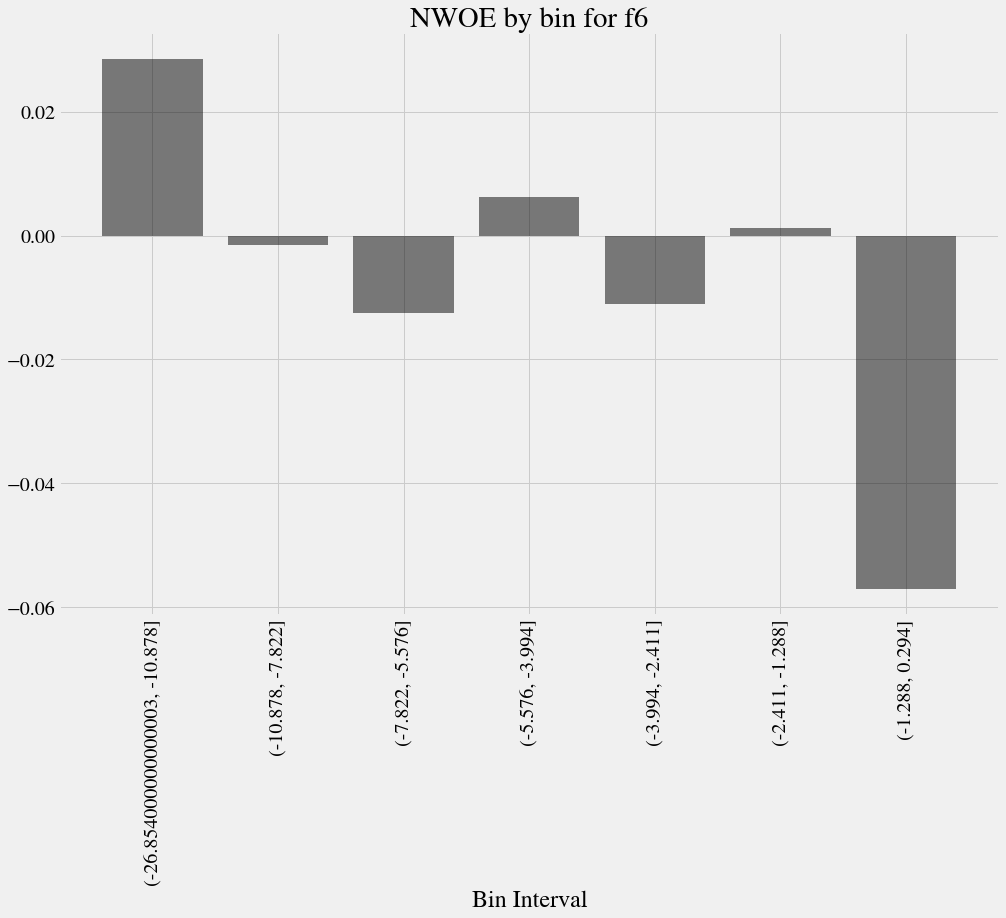

In [36]:
tmp.NWOE(feats_to_use=['f6'], n_bins=10)

<AxesSubplot:xlabel='NIV', ylabel='Features'>

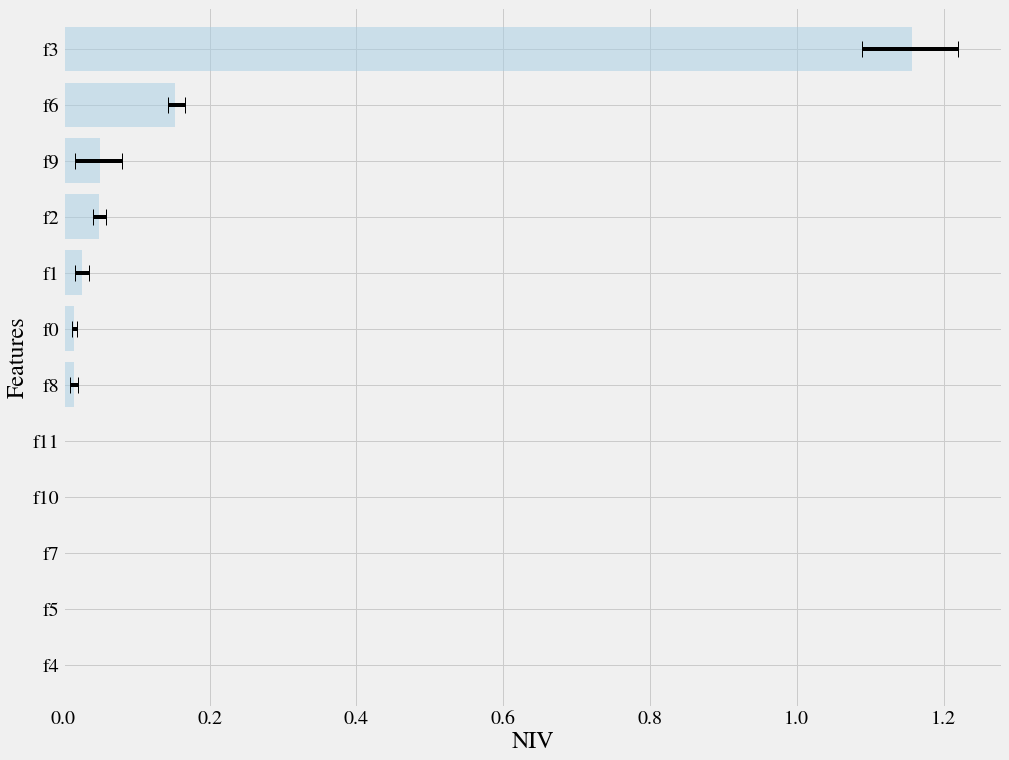

In [37]:
tmp.NIV(n_bins=10)

<AxesSubplot:xlabel='NIV', ylabel='Features'>

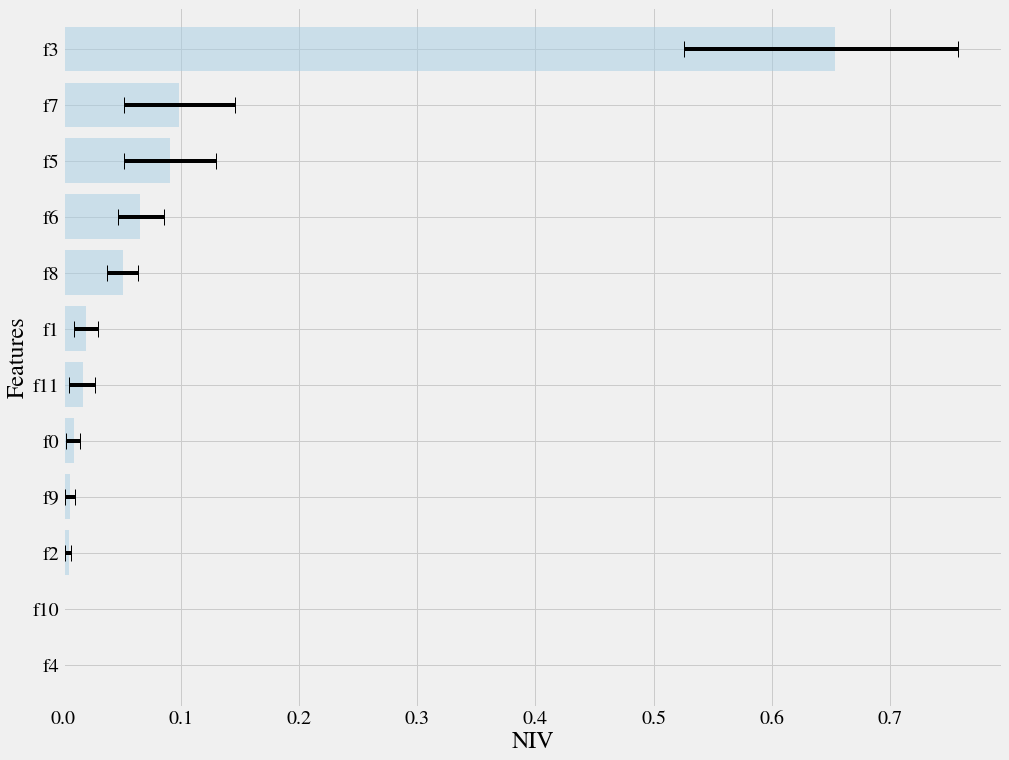

In [38]:
tmp.NIV(n_bins=20)

<AxesSubplot:title={'center':'NWOE by bin for f3'}, xlabel='Bin Interval'>

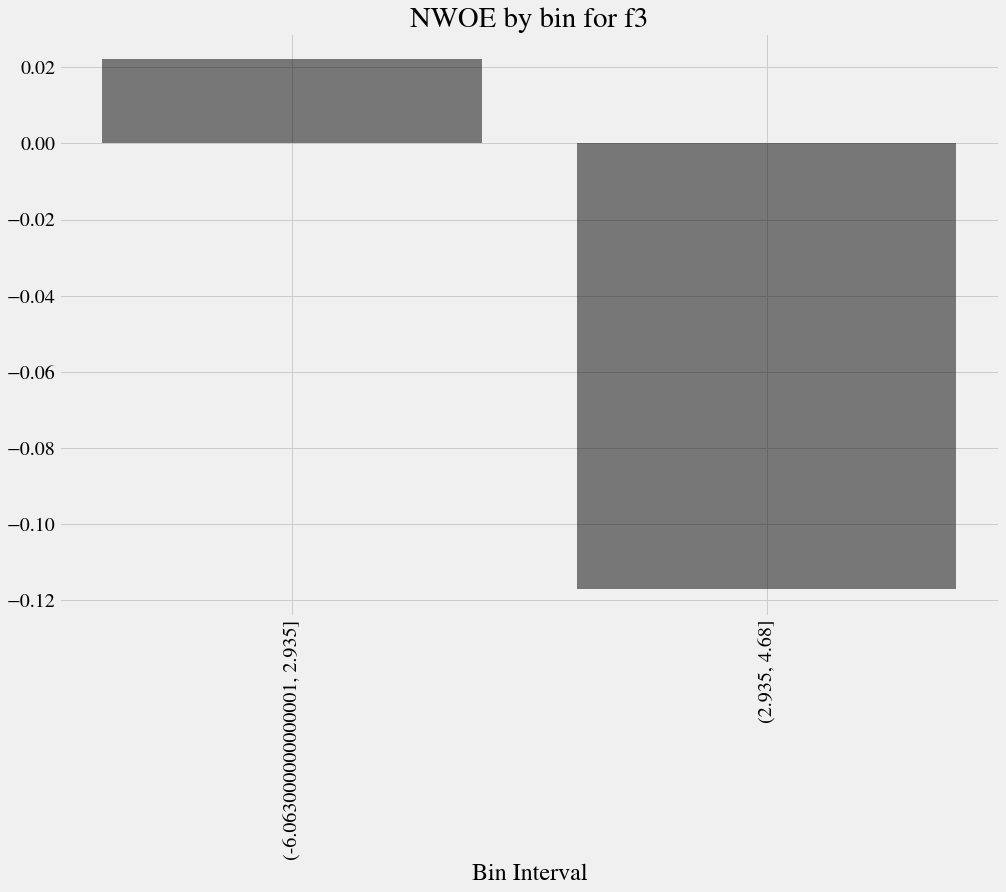

In [39]:
tmp.NWOE(feats_to_use=['f3'], n_bins=10)

In [40]:
data.loc[fit_index, 'f3'].value_counts()

 4.679882    9155911
 3.907662     458548
 3.359763     247197
 2.934780     171558
 2.587543     129588
              ...   
-6.548797          1
-6.239429          1
-6.088782          1
-7.700578          1
-5.996527          1
Name: f3, Length: 532, dtype: int64

## Experiments

### exp n.11 - T-learner

In [41]:
import causalml.inference.meta.tlearner as tlearner

#### build model

In [42]:
model_n11 = tlearner.BaseTRegressor(
    learner=lgb.LGBMRegressor(),
    control_name=0
)

In [43]:
model_n11.fit(
    X=data.loc[fit_index, cols_features].values,
    treatment=data.loc[fit_index, col_treatment].values,
    y=data.loc[fit_index, 'visit'].values,
)

#### evaluate model

In [44]:
_eval_data = data.loc[val_index, cols_features + [col_treatment, 'visit']]
_eval_data['score'] = model_n11.predict(_eval_data[cols_features])
_eval_data = _eval_data[['score', col_treatment, 'visit']]

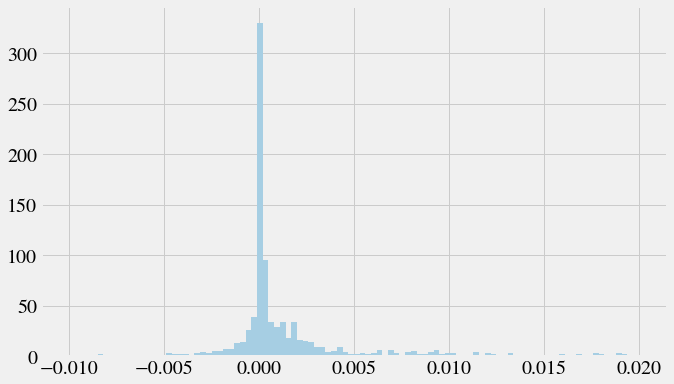

In [45]:
plt.figure(figsize=(10, 6))
plt.hist(_eval_data['score'].head(1000), range=(-0.01, 0.02), bins=100)
plt.show()

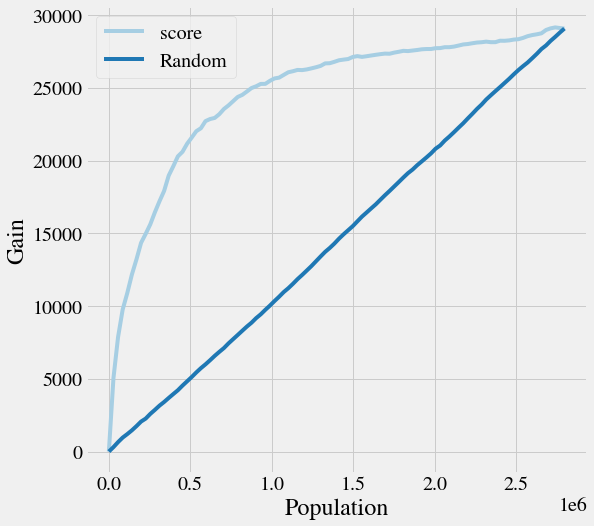

In [46]:
cmetrics.plot_gain(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col='visit',
)

In [47]:
cmetrics.auuc_score(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col='visit',
)

score     0.845630
Random    0.497666
dtype: float64

In [48]:
cmetrics.qini_score(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col='visit',
)

score     0.351733
Random    0.000000
dtype: float64

### exp n.4 - X-learner

In [49]:
import causalml.inference.meta.xlearner as xlearner

#### build model

In [50]:
model_n4 = xlearner.BaseXRegressor(
    learner=lgb.LGBMRegressor(),
    control_name=0
)

In [51]:
_p_score_const = data.loc[fit_index, col_treatment].value_counts(normalize=True).loc[1]
_p_scores = pd.Series(data=_p_score_const, index=fit_index)

In [52]:
_p_score_const

0.8500528404219257

In [53]:
_p_scores

9376485     0.850053
8381971     0.850053
4983415     0.850053
6908008     0.850053
2236256     0.850053
              ...   
7363129     0.850053
3327930     0.850053
11248348    0.850053
5974946     0.850053
8607680     0.850053
Length: 11183673, dtype: float64

In [54]:
model_n4.fit(
    X=data.loc[fit_index, cols_features].values,
    treatment=data.loc[fit_index, col_treatment].values, # .apply(lambda t: 'treatment' if t == 1 else 'control').values,
    y=data.loc[fit_index, 'visit'].values,
    p=_p_scores
)

#### evaluate model

In [55]:
_p_scores = pd.Series(data=_p_score_const, index=val_index)

_eval_data = data.loc[val_index, cols_features + [col_treatment, 'visit']]
_eval_data['score'] = model_n4.predict(_eval_data[cols_features], p=_p_scores)
_eval_data = _eval_data[['score', col_treatment, 'visit']]

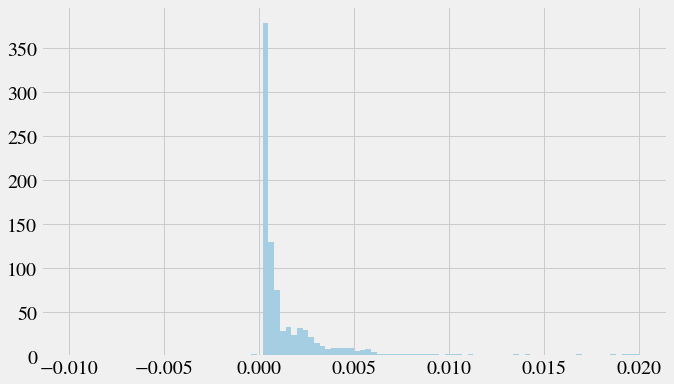

In [56]:
plt.figure(figsize=(10, 6))
plt.hist(_eval_data['score'].head(1000), range=(-0.01, 0.02), bins=100)
plt.show()

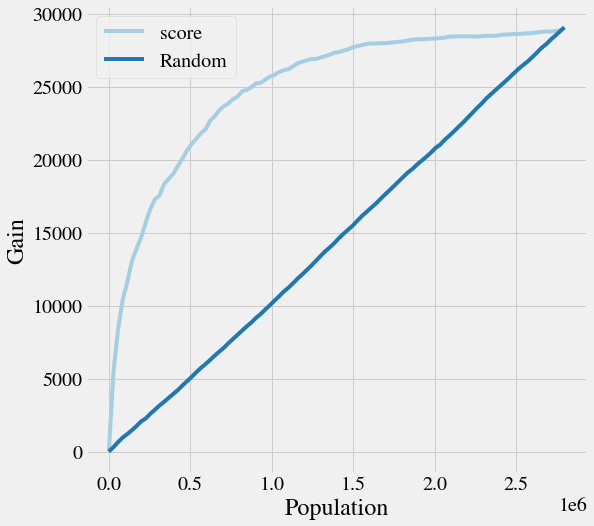

In [57]:
cmetrics.plot_gain(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col='visit',
)

In [58]:
cmetrics.auuc_score(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col='visit',
)

score     0.856371
Random    0.497666
dtype: float64

In [59]:
cmetrics.qini_score(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col='visit',
)

score     0.362428
Random    0.000000
dtype: float64

### exp n.6 - R-learner

In [60]:
import causalml.inference.meta.rlearner as rlearner

#### build model

In [61]:
model_rl = rlearner.BaseRRegressor(
    learner=lgb.LGBMRegressor(),
    control_name=0
)

In [62]:
_p_score_const = data.loc[fit_index, col_treatment].value_counts(normalize=True).loc[1]
_p_scores = pd.Series(data=_p_score_const, index=fit_index)
model_rl.fit(
    X=data.loc[fit_index, cols_features].values,
    treatment=data.loc[fit_index, col_treatment].values,
    y=data.loc[fit_index, 'visit'].values,
    p=_p_scores
)

#### evaluate model

In [63]:
_eval_data = data.loc[val_index, cols_features + [col_treatment, 'visit']]
_eval_data['score'] = model_rl.predict(_eval_data[cols_features])
_eval_data = _eval_data[['score', col_treatment, 'visit']]

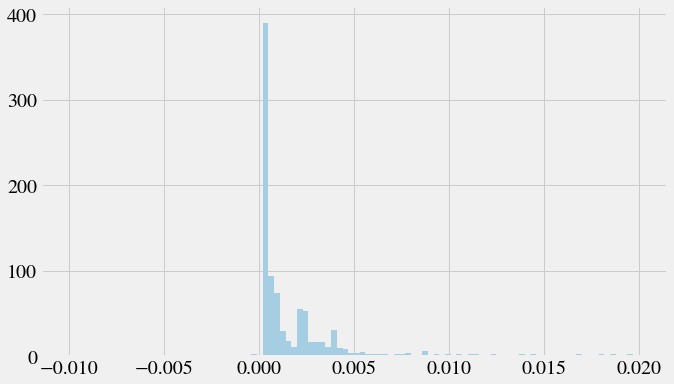

In [64]:
plt.figure(figsize=(10, 6))
plt.hist(_eval_data['score'].head(1000), range=(-0.01, 0.02), bins=100)
plt.show()

In [65]:
_eval_data['score'].describe()

count    2.795919e+06
mean     7.288603e-03
std      2.336141e-02
min     -6.323989e-01
25%      3.154303e-04
50%      7.979355e-04
75%      2.932799e-03
max      6.060000e-01
Name: score, dtype: float64

In [66]:
np.percentile(_eval_data['score'], 95)

0.042114642218651334

In [67]:
np.percentile(_eval_data['score'], 99)

0.12428524145941075

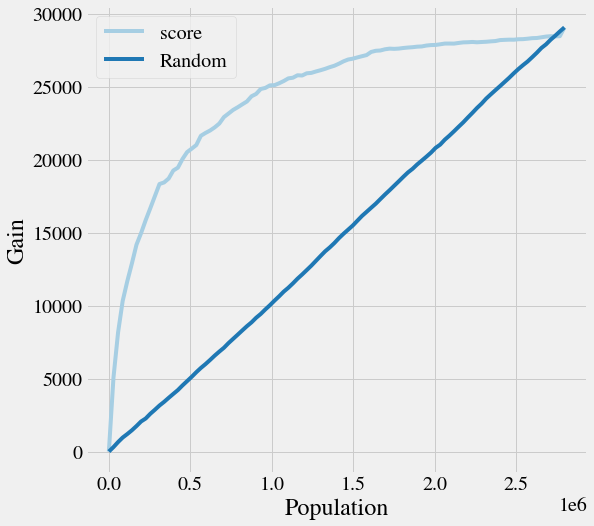

In [68]:
cmetrics.plot_gain(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col='visit',
)

In [69]:
cmetrics.auuc_score(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col='visit',
)

score     0.840713
Random    0.497666
dtype: float64

In [70]:
cmetrics.qini_score(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col='visit',
)

score     0.346725
Random    0.000000
dtype: float64

### exp n.3 - Transformed Outcome

#### description

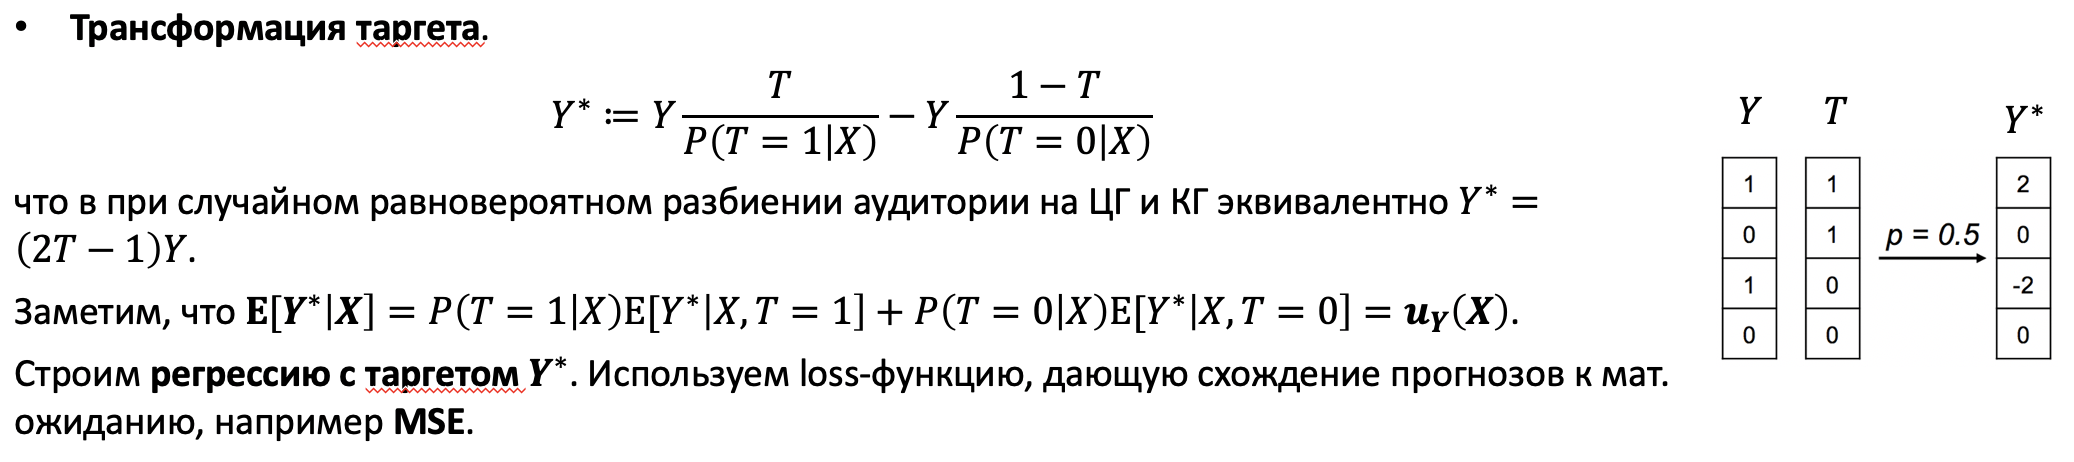

#### build model

In [71]:
model_n3 = pylift.TransformedOutcome(
    data.loc[fit_index, cols_features + [col_treatment, 'visit']],
    col_treatment=col_treatment, col_outcome='visit',
    test_size=2
)

In [72]:
model_n3.fit()

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


#### evaluate model

In [73]:
_eval_data = data.loc[val_index, cols_features + [col_treatment, 'visit']]
_eval_data['score'] = model_n3.model.predict(_eval_data[cols_features])
_eval_data = _eval_data[['score', col_treatment, 'visit']]

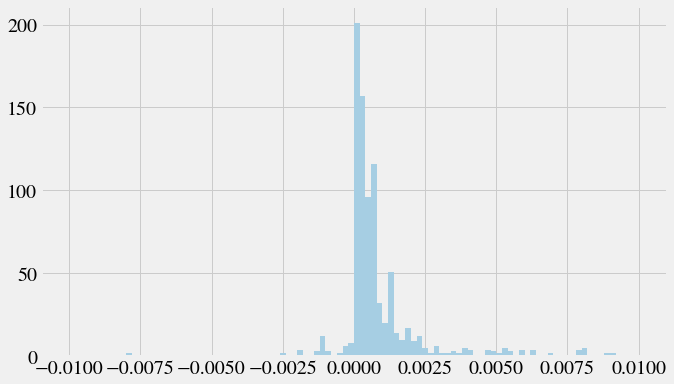

In [74]:
plt.figure(figsize=(10, 6))
plt.hist(_eval_data['score'].head(1000), range=(-0.01, 0.01), bins=100)
plt.show()

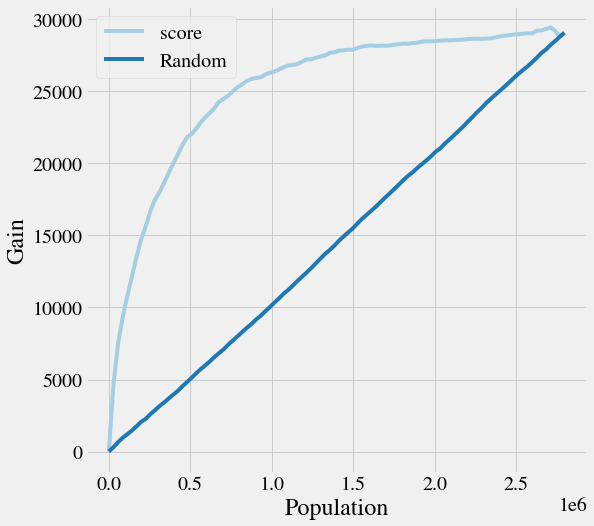

In [75]:
cmetrics.plot_gain(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col='visit',
)

In [76]:
cmetrics.auuc_score(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col='visit',
)

score     0.868257
Random    0.497666
dtype: float64

In [77]:
cmetrics.qini_score(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col='visit',
)

score     0.374639
Random    0.000000
dtype: float64

### exp n.9 - Tree KL (depth 3)

In [78]:
import causalml.inference.tree as ctree

#### build model

In [79]:
model_n9 = ctree.UpliftRandomForestClassifier(
    control_name='control',
    evaluationFunction='KL',
    n_estimators=20,
    max_depth=3,
    min_samples_leaf=500
)

In [80]:
model_n9.fit(
    X=data.loc[fit_sample_index, cols_features].values,
    treatment=data.loc[fit_sample_index, col_treatment].apply(lambda t: 'treatment' if t == 1 else 'control').values,
    y=data.loc[fit_sample_index, 'visit'].values
)

#### evaluate model

In [81]:
_eval_data = data.loc[val_index, cols_features + [col_treatment, 'visit']]
_eval_data['score'] = model_n9.predict(_eval_data[cols_features].values)
_eval_data = _eval_data[['score', col_treatment, 'visit']]

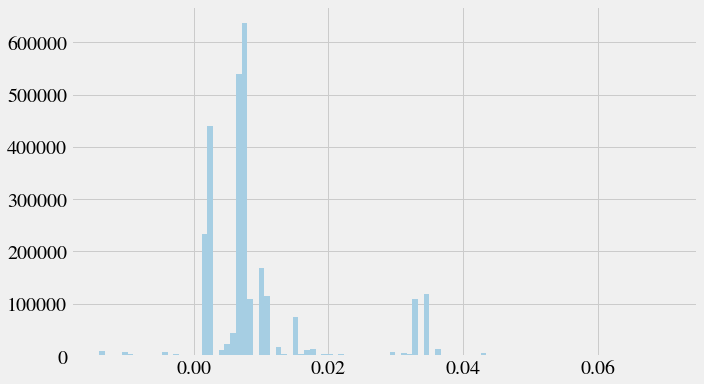

In [82]:
plt.figure(figsize=(10, 6))
plt.hist(_eval_data['score'], bins=100)
plt.show()

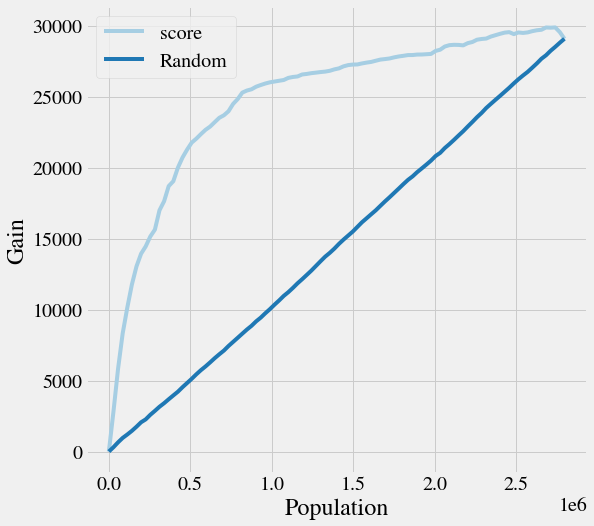

In [83]:
cmetrics.plot_gain(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col='visit',
)

In [84]:
cmetrics.auuc_score(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col='visit',
)

score     0.855899
Random    0.497666
dtype: float64

In [85]:
cmetrics.qini_score(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col='visit',
)

score     0.362511
Random    0.000000
dtype: float64

In [86]:
graph = ctree.uplift_tree_plot(model_n9.uplift_forest[0].fitted_uplift_tree, cols_features)
Image(graph.create_png())

InvocationException: GraphViz's executables not found

### exp n.10 - Tree KL (depth 6)

#### build model

In [ ]:
model_n10 = ctree.UpliftRandomForestClassifier(
    control_name='control',
    evaluationFunction='KL',
    n_estimators=30,
    max_depth=6,
    min_samples_leaf=500
)

In [ ]:
model_n10.fit(
    X=data.loc[fit_sample_index, cols_features].values,
    treatment=data.loc[fit_sample_index, col_treatment].apply(lambda t: 'treatment' if t == 1 else 'control').values,
    y=data.loc[fit_sample_index, 'visit'].values
)

#### evaluate model

In [ ]:
_eval_data = data.loc[val_index, cols_features + [col_treatment, 'visit']]
_eval_data['score'] = model_n10.predict(_eval_data[cols_features].values)
_eval_data = _eval_data[['score', col_treatment, 'visit']]

In [ ]:
from causalml.inference.tree import UpliftRandomForestClassifier

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(_eval_data['score'], bins=100)
plt.show()

In [ ]:
cmetrics.plot_gain(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col='visit',
)

In [ ]:
cmetrics.auuc_score(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col='visit',
)

In [ ]:
cmetrics.qini_score(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col='visit',
)

In [ ]:
graph = ctree.uplift_tree_plot(model_n10.uplift_forest[0].fitted_uplift_tree, cols_features)
Image(graph.create_png())

### exp n.7 - Tree CTS (depth 6)

#### build model

In [ ]:
model_n7 = ctree.UpliftRandomForestClassifier(
    control_name='control',
    evaluationFunction='CTS',
    n_estimators=10,
    max_depth=6,
    min_samples_leaf=500
)

In [ ]:
model_n7.fit(
    X=data.loc[fit_sample_index, cols_features].values,
    treatment=data.loc[fit_sample_index, col_treatment].apply(lambda t: 'treatment' if t == 1 else 'control').values,
    y=data.loc[fit_sample_index, 'visit'].values
)

#### evaluate model

In [ ]:
_eval_data = data.loc[val_index, cols_features + [col_treatment, 'visit']]
_eval_data['score'] = model_n7.predict(_eval_data[cols_features].values)
_eval_data = _eval_data[['score', col_treatment, 'visit']]

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(_eval_data['score'], bins=100)
plt.show()

In [ ]:
cmetrics.plot_gain(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col='visit',
)

In [ ]:
cmetrics.auuc_score(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col='visit',
)

In [ ]:
cmetrics.qini_score(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col='visit',
)

### exp n.8 - Tree CTS (depth 3)

#### build model

In [ ]:
model_n8 = ctree.UpliftRandomForestClassifier(
    control_name='control',
    evaluationFunction='CTS',
    n_estimators=20,
    max_depth=3,
    min_samples_leaf=500
)

#### evaluate model

In [ ]:
_eval_data = data.loc[val_index, cols_features + [col_treatment, 'visit']]
_eval_data['score'] = model_n8.predict(_eval_data[cols_features].values)
_eval_data = _eval_data[['score', col_treatment, 'visit']]

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(_eval_data['score'], bins=100)
plt.show()

In [ ]:
cmetrics.plot_gain(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col='visit',
)

In [ ]:
cmetrics.auuc_score(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col='visit',
)

In [ ]:
cmetrics.qini_score(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col='visit',
)

In [ ]:
graph = ctree.uplift_tree_plot(model_n8.uplift_forest[0].fitted_uplift_tree, cols_features)
Image(graph.create_png())

### final comparison

In [ ]:
final_eval_data['transformed_outcome'] = _eval_data['score']

In [ ]:
final_eval_data = data.loc[val_index, cols_features + [col_treatment, 'visit']]

In [ ]:
_p_score_const = data.loc[fit_index, col_treatment].value_counts(normalize=True).loc[1]
_p_scores = pd.Series(data=_p_score_const, index=val_index)

In [ ]:
final_eval_data['t_learner'] = model_n11.predict(final_eval_data[cols_features].values)
final_eval_data['x_learner'] = model_n4.predict(final_eval_data[cols_features].values, p=_p_scores)
final_eval_data['r_learner'] = model_rl.predict(final_eval_data[cols_features].values)
final_eval_data['transformed_outcome'] = model_n3.predict(final_eval_data[cols_features].values)

In [ ]:
final_eval_data['tree_KL'] = model_n9.predict(final_eval_data[cols_features].values)
final_eval_data['tree_CTS'] = model_n8.predict(final_eval_data[cols_features].values)

In [ ]:
final_eval_data.drop(columns=cols_features, inplace=True)

In [ ]:
cmetrics.plot_gain(
    final_eval_data,
    treatment_col=col_treatment,
    outcome_col='visit',
)

In [ ]:
cmetrics.auuc_score(
    final_eval_data,
    treatment_col=col_treatment,
    outcome_col='visit',
)

In [ ]:
cmetrics.qini_score(
    final_eval_data,
    treatment_col=col_treatment,
    outcome_col='visit',
)